# Import libraries

In [51]:
%load_ext autoreload
%autoreload 2
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf, pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.api as sm
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA, ARMA
from matplotlib import pyplot
import pandas as pd
import numpy as np
from atomm.DataManager.main import MSDataManager
import pandas as pd
import os
from pathlib import Path

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

In [3]:
# Load environment variables (data base directory, API keys, etc)
load_dotenv(find_dotenv())

True

# Obtain data

## One year of MSFT data

In [44]:
dm = MSDataManager()

In [45]:
sym = 'AAPL'

In [46]:
dm.ReturnLatestStoredDate(sym)

Timestamp('2020-01-09 00:00:00+0000', tz='UTC')

In [59]:
sym='AAPL'
p = dm.ReturnData(sym, limit=1050)['Close']
aapl = pd.DataFrame(p, columns=['Close'])
aapl['log_ret'] = np.log(df['Close']).diff()
aapl['log_ret'].fillna(method='bfill', inplace=True)

In [60]:
sym='MSFT'
p = dm.ReturnData(sym, limit=1050)['Close']
msft = pd.DataFrame(p, columns=['Close'])
msft['log_ret'] = np.log(df['Close']).diff()
msft['log_ret'].fillna(method='bfill', inplace=True)

## The 50 randomly selected stocks

In [7]:
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')

fname = os.path.join(data_base_dir, 'processed', 'index.h5')
fname = Path(fname)
# Load dataset from HDF storage
with pd.HDFStore(fname) as storage:
    djia = storage.get('nyse/cleaned/rand_symbols')
    y_2c = storage.get('nyse/engineered/target_two_class')
    y_3c = storage.get('nyse/engineered/target_three_class')
    df_moments = storage.get('nyse/engineered/features')
    #print(storage.info())
    
# Create copies of the pristine data
X = df_moments.copy()
y = y_3c.copy()
y2 = y_2c.copy()
prices = djia.copy()

# Correlogram

## Define correlogram plotting function

In [52]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.4f}\nADF: {adfuller(x)[1]:>11.4E}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.4f}\nSD: {np.sqrt(var):>16.4f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.4f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Close price undifferenced

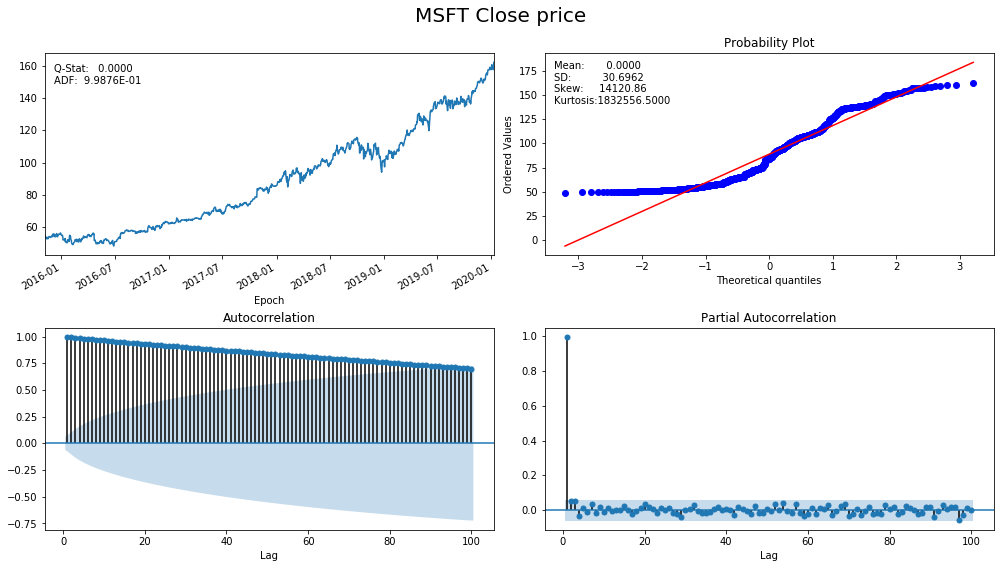

In [61]:
plot_correlogram(msft['Close'], lags=100, title=f'{sym} Close price')

## Close price log diff

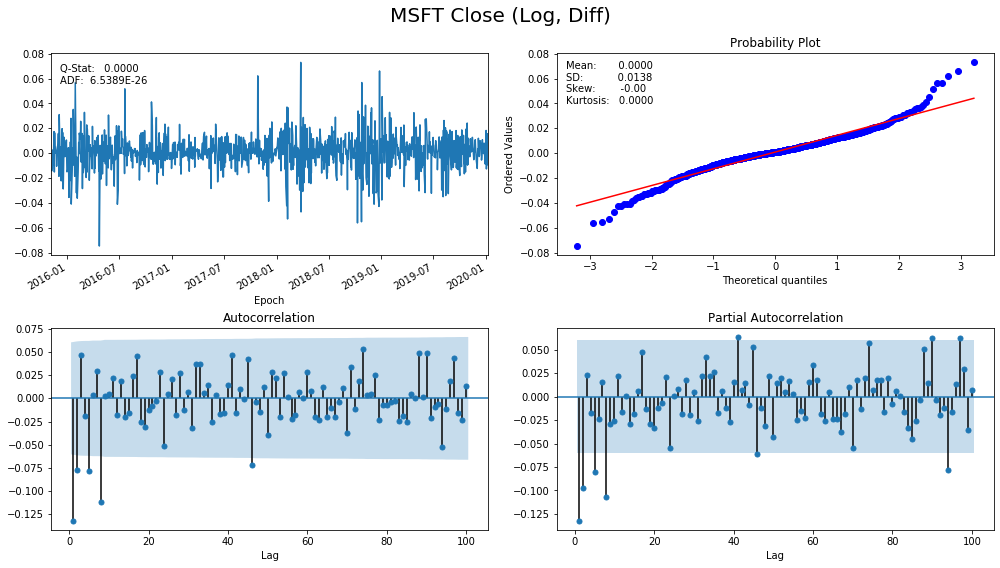

In [62]:
plot_correlogram(msft['log_ret'], lags=100, title=f'{sym} Close (Log, Diff)')

# ARIMA model as feature

In [70]:
def ARMAtrend(data, d_lookahead, d_lookback, thresh=0.01, order=(2, 2)):
    preds = np.array([np.nan]*len(data))    
    for i in range(d_lookback, len(data)):
        model = ARMA(data[:d_lookback].values, order=order)
        model_fit = model.fit(disp=0,)
        prediction = model_fit.forecast(steps=d_lookahead)
        preds[i] = prediction[0][-1]
        data = data[1:]
    return preds

def ARIMAtrend(data, d_lookahead, d_lookback, thresh=0.01, order=(2, 1, 0)):
    preds = np.array([np.nan]*len(data))    
    for t in range(d_lookback, len(data)):
        model = ARIMA(data[t-d_lookback:t+d_lookahead].values, order=order)
        model_fit = model.fit(disp=0,)
        prediction = model_fit.forecast(steps=d_lookahead)
        preds[t] = prediction[0][-1]
        #data = data[1:]
    return preds

## Check 'log_ret' stationarity

In [64]:
from statsmodels.tsa.stattools import adfuller
print("p-value:", adfuller(msft['log_ret'])[1])

p-value: 6.538856030686327e-26


In [63]:
da = msft.copy()

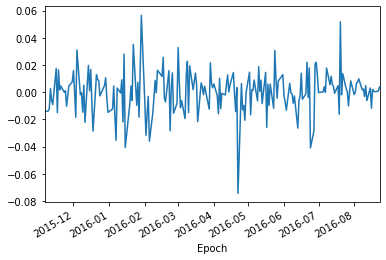

In [65]:
da['log_ret'][:200].plot()

In [184]:
model = ARIMA(aapl['Close'][:10].values, order=(1, 1, 0))
model_fit = model.fit(disp=0,)
prediction = model_fit.forecast(steps=1)
pred = prediction[0][-1]
true = aapl['Close'][10]
error = mean_squared_error([aapl['Close'][10]], [true])
error

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [73]:
import warnings

In [76]:
warnings.filterwarnings(action='ignore')
d_lookahead=1
d_lookback=15
sig = ARIMAtrend(da['Close'], d_lookahead, d_lookback, order=(2, 1, 0))

In [79]:
df['arima_signal'] = sig
df['arima_signal'] = np.log(df['arima_signal']).diff()

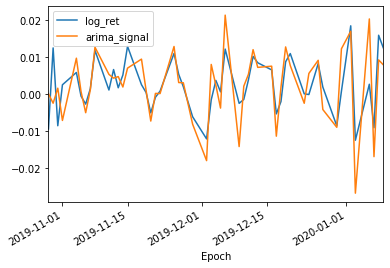

In [85]:
df[['log_ret', 'arima_signal']][-50:].plot()
#df['arima_signal'].shift(-1).plot()

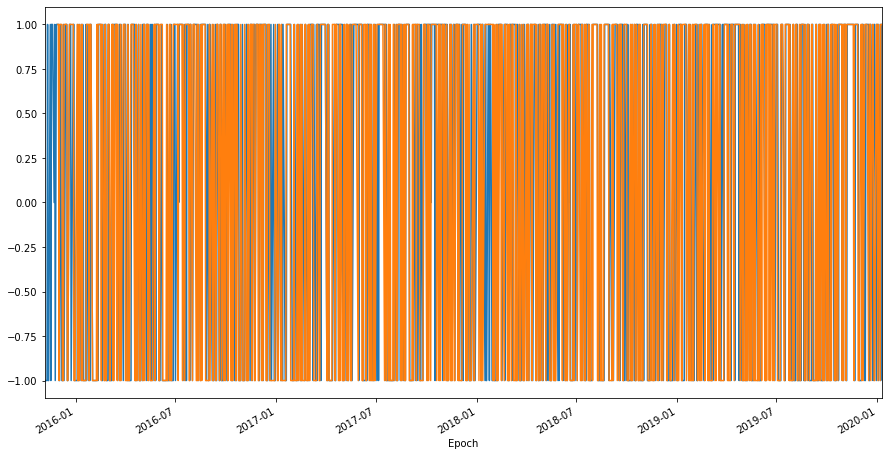

In [86]:
plt.figure(figsize=(15, 8))
df['log_ret_sign'] = np.sign(df['log_ret'])
df['log_ret_sign'].plot()
df['arima_signal_sign'] = np.sign(df['arima_signal'])
df['arima_signal_sign'].shift(-1).plot()

In [92]:
sum(df['log_ret_sign'][d_lookback:] == df['arima_signal_sign'][d_lookback:])

832

## Finding optimal p, d, q parameters

In [389]:
train_size = 120
test_results = {}
y_true = da['log_ret'].iloc[train_size:].values
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(da['log_ret'])):
            train_set = da['log_ret'].iloc[T-train_size:T].values
            try:
                model = tsa.ARMA(endog=train_set, order=(p, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1
            forecast, _, _ = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        test_results[(p, q)] = [rmse,
                                np.mean(aic),
                                np.mean(bic),
                                convergence_error,
                                stationarity_error]

0 1


//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 2
0 3


//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 4
1 0


//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 1


NameError: name 'LinAlgError' is not defined

# autoARIMA for hyperparameter tuning

In [41]:
from pyramid.arima import auto_arima

ModuleNotFoundError: No module named 'pyramid.arima'